# Setup

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import grad
import jax
import matplotlib.pyplot as plt
import networkx as nx
from sklearn import datasets
import optax  

# Load the Iris dataset 

In [2]:
ds = datasets.load_breast_cancer()
X = ds.data


X[:10]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

In [3]:
# Calculate a similarity matrix 
sim_matrix = 1 - np.abs(np.corrcoef(X.T))
sim_matrix

array([[0.00000000e+00, 6.76218109e-01, 2.14471851e-03, 1.26428299e-02,
        8.29418813e-01, 4.93876422e-01, 3.23236450e-01, 1.77471478e-01,
        8.52258758e-01, 6.88369174e-01, 3.20909612e-01, 9.02682557e-01,
        3.25828384e-01, 2.64136337e-01, 7.77399875e-01, 7.94000020e-01,
        8.05796377e-01, 6.23831044e-01, 8.95679119e-01, 9.57358731e-01,
        3.04610274e-02, 7.02992356e-01, 3.48634860e-02, 5.89175404e-02,
        8.80383860e-01, 5.86537177e-01, 4.73088538e-01, 2.55785802e-01,
        8.36046665e-01, 9.92934114e-01],
       [6.76218109e-01, 2.22044605e-16, 6.70466941e-01, 6.78914304e-01,
        9.76611484e-01, 7.63297778e-01, 6.97582172e-01, 7.06535949e-01,
        9.28599020e-01, 9.23562817e-01, 7.24131324e-01, 6.13642377e-01,
        7.18326885e-01, 7.40155013e-01, 9.93386223e-01, 8.08025389e-01,
        8.56706923e-01, 8.36148975e-01, 9.90872832e-01, 9.45542480e-01,
        6.47427053e-01, 8.79554112e-02, 6.41960425e-01, 6.56454053e-01,
        9.22496641e-01,

# Train

In [56]:
# Function to construct the precision matrix
def construct_precision_matrix(params, p):
  lambda_ = 0.0009

  precision_matrix = jnp.zeros((p, p))
  for i in range(p):
    for j in range(i, p):
      if i != j:
        precision_matrix = precision_matrix.at[i, j].set(params[i * p + j])
      
  precision_matrix += precision_matrix.T
  precision_matrix += jnp.diag(jnp.diag(precision_matrix)) # Using jnp.diag 

  # Soft-thresholding for L1 regularization
  precision_matrix = jnp.sign(precision_matrix) * jnp.maximum(jnp.abs(precision_matrix) - lambda_, 0)
  return precision_matrix

# Define the squared loss function
@jax.jit
def squared_loss(params, X):
  n, p = X.shape
  predicted_precision = construct_precision_matrix(params, p)
  empirical_cov = (1 / n) * jnp.dot(X.T, X)
  return 0.5 * jnp.trace(jnp.dot(predicted_precision, empirical_cov)) + jnp.sum(jnp.abs(params))


In [57]:
p = X.shape[1]
key = jax.random.PRNGKey(758493)  # Random seed is explicit in JAX
params = jax.random.uniform(key, (p * (p + 1) // 2, ))
display(params)

# Optimization setup (using Optax)
loss_grad = grad(squared_loss)  
optimizer = optax.adam(0.01) 
opt_state = optimizer.init(params) 

# Training loop with Optax update
for i in range(1000):
  updates, opt_state = optimizer.update(loss_grad(params, sim_matrix), opt_state)
  params = optax.apply_updates(params, updates)
  if i % 100 == 0:
    print(f"Loss at step {i} is {squared_loss(params, sim_matrix)}")

Array([2.12556481e-01, 7.66499519e-01, 4.12260294e-01, 4.31970954e-01,
       3.24066758e-01, 9.63050008e-01, 2.31991529e-01, 3.94723177e-01,
       6.33898616e-01, 4.79666710e-01, 5.30824065e-01, 1.53066039e-01,
       7.74438381e-02, 5.52717209e-01, 7.90827036e-01, 6.11196399e-01,
       6.03530169e-01, 3.75550866e-01, 4.48663712e-01, 7.17019558e-01,
       1.52476907e-01, 7.00184345e-01, 6.61565185e-01, 9.83652949e-01,
       8.51175308e-01, 9.84339356e-01, 3.63736629e-01, 6.50739431e-01,
       6.08858824e-01, 3.11689854e-01, 4.43648577e-01, 5.77308178e-01,
       5.39145231e-01, 3.86482239e-01, 5.57479501e-01, 9.61340189e-01,
       2.62226939e-01, 2.75075674e-01, 7.75834084e-01, 1.50727034e-02,
       2.17614770e-01, 8.02369475e-01, 9.66788650e-01, 7.44150519e-01,
       1.29528284e-01, 2.49968767e-01, 9.66143250e-01, 6.11979365e-01,
       6.17968082e-01, 9.91850019e-01, 6.20056033e-01, 2.21203566e-02,
       9.17508602e-01, 9.94626164e-01, 6.22537732e-01, 8.95908713e-01,
      

Loss at step 0 is 309.3995666503906
Loss at step 100 is 2.9103524684906006
Loss at step 200 is 0.45053961873054504
Loss at step 300 is 0.48802122473716736
Loss at step 400 is 0.45663246512413025
Loss at step 500 is 0.4206104874610901
Loss at step 600 is 0.45402541756629944
Loss at step 700 is 0.4454691708087921
Loss at step 800 is 0.37229055166244507
Loss at step 900 is 0.38478565216064453


In [58]:
# Estimated precision and covariance matrices
estimated_precision_matrix = construct_precision_matrix(params, p)
estimated_covariance_matrix = jnp.linalg.inv(estimated_precision_matrix)

display(estimated_precision_matrix)

Array([[ 0.0000000e+00,  0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -6.8606576e-05,
         0.0000000e+00,  1.6977879e-03,  0.0000000e+00,  0.0000000e+00,
         2.2146793e-04, -0.0000000e+00, -0.0000000e+00, -1.5413003e-03,
        -0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
         0.0000000e+00,  0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -0.0000000e+00, -1.7036019e-03,
         0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -8.6127454e-04,
         0.0000000e+00,  0.0000000e+00, -0.0000000e+00,  2.1819829e-04,
        -1.6461796e-03, -3.2515922e-03, -0.0000000e+00, -5.0068707e-03,
         0.0000000e+00, -2.4984055e-04,  0.0000000e+00,  0.0000000e+00,
        -0.0000000e+00,  0.0000000e+00, -0.0000000e+00, -2.0586913e-03,
        -0.0000000e+00,

# Visualization



In [59]:
estimated_covariance_matrix

Array([[ 1.15956186e-06, -2.80561972e-06,  2.87941832e-04,
        -1.30422870e-06,  8.65703953e-07,  5.53531791e-05,
        -1.90396374e-03,  6.78042625e-07, -1.04338338e-03,
        -4.14675778e-05, -1.21643745e+02, -5.13367355e-04,
         6.15665795e-06,  4.25897724e-06, -1.69396895e-04,
        -6.48803833e+02, -6.47652930e+03, -1.19220955e+02,
        -9.67660248e-01,  7.14581966e+00, -7.56280904e-04,
         5.07437799e-04, -2.45436895e-05, -1.21022438e+02,
         1.89764233e+03, -1.80294458e+03, -5.68143674e-04,
        -2.03440938e+04,  3.15830498e+01, -1.35453994e+04],
       [-2.21541518e-06,  1.32317314e-06, -9.04154876e-05,
        -2.30296064e-06, -2.37522045e-07, -3.09378920e-05,
         5.73227124e-04, -2.35042805e-07,  3.21211963e-04,
         9.44908334e-06, -9.54365845e+01,  1.85186829e-04,
        -1.67417636e-06, -4.47420780e-06,  4.52407403e-05,
         2.47593678e-04,  9.96323608e+02,  1.91652145e+01,
         3.65129620e-01, -1.01393175e+00,  2.27916069e-

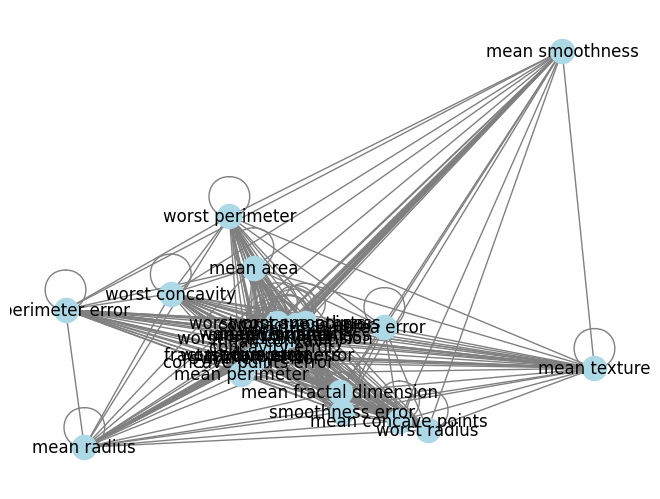

In [60]:
# from scipy import sparse
# A = np.abs(estimated_covariance_matrix)
# A = sparse.csr_matrix(A)
# nx.from_scipy_sparse_array(A, create_using=nx.MultiGraph)

G = nx.from_numpy_array(np.abs(estimated_covariance_matrix))
G = nx.relabel_nodes(G, {i: names for i, names in enumerate(ds.feature_names)})

# G = nx.complete_graph(p)
nx.draw(G, nx.spring_layout(G), node_color='lightblue', edge_color='gray', with_labels=True) 
plt.show()

In [61]:
ds.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')